# 1. Data Preprocessing
## Import Dependencies

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test_round2.csv
./data/.DS_Store
./data/train_round2.csv
./data/graph_round2.csv
./data/test.csv
./data/graph.csv
./data/submission_round2.csv
./data/submission.csv
./data/train.csv


## Load Data

In [3]:
data_dir = 'data'
temporal_data_path = os.path.join(data_dir, 'train_round2.csv')
mobility_data_path = os.path.join(data_dir, 'graph_round2.csv')

temporal_data = pd.read_csv(temporal_data_path)
temporal_data.describe()
#  training data from 04/12/2020 to 11/22/2020.

,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,11250.000000,1.125000e+04,11250.000000,9419.000000,1.125000e+04,11250.000000,1.055000e+04,5047.000000,10550.000000,11250.000000,5047.000000
mean,5624.500000,9.583625e+04,3057.178311,40276.189086,5.907248e+04,1357.938709,1.161268e+06,6250.044185,3.300561,20085.845676,12.197144
std,3247.739599,1.516621e+05,5377.615328,81746.843553,1.243728e+05,1199.193935,2.031813e+06,13880.694435,2.039538,19319.956138,5.255183
min,0.000000,2.700000e+02,0.000000,0.000000,-9.890000e+02,32.771004,5.459000e+03,10.000000,0.000000,460.300152,2.302896
25%,2812.250000,1.054600e+04,273.000000,3030.500000,4.599500e+03,374.587118,1.579640e+05,595.000000,1.708176,5761.788808,8.387037
50%,5624.500000,4.175800e+04,1031.000000,10376.000000,1.579100e+04,1045.850447,4.901655e+05,2068.000000,2.802207,15172.226199,11.351161
75%,8436.750000,1.174958e+05,3387.000000,48028.000000,5.289675e+04,2046.182244,1.247765e+06,6134.500000,4.425834,27209.961598,15.396088
max,11249.000000,1.153529e+06,34319.000000,913796.000000,1.095798e+06,9537.675412,1.956515e+07,89995.000000,9.741481,134755.702292,38.501190


In [4]:
# # First, we will get the total confirmed/deaths of each state
# states = list(np.unique(train_data['Province_State']))
# collected = ['Confirmed', 'Deaths', 'People_Tested']
# states_data = dict.fromkeys(states, None)
# state_scaler = {}

# for s in states:
#     df_filter = train_data['Province_State'] == s
#     state_df = train_data[df_filter]
#     states_data[s] = state_df.drop(['Date','Deaths','Active','ID', 'Province_State', 'Incident_Rate', 'Recovered', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate'], 1)
#     save_columns = states_data[s].columns
#     state_scaler[s] = StandardScaler()
# #     state_scaler[s] = MinMaxScaler()
#     states_data[s] = state_scaler[s].fit_transform(states_data[s])
#     states_data[s] = pd.DataFrame(states_data[s], columns=save_columns)
    
# states_data['California']  

In [5]:
# num_states = len(states_data.keys())
# state_count = 1
# figure_count = 1;
# plt.figure(figsize=(20, 20))
# for state in states_data.keys():
#     if state_count == 1:
#         plt.subplot(2,3,figure_count)
#         plt.yscale('linear')
#     plt.plot(states_data[state].Confirmed.values, label=f"{state}: Comfirmed")
#     plt.legend(loc='best')
#     state_count += 1
#     if state_count == 11:
#         state_count %= 10
#         figure_count += 1
        
# plt.subplot(1,2,2)
# plt.plot(states_data['California'].Deaths.values, color='blue', label='Deaths')
# plt.legend(loc='best')


## Visualize the Trend of One State

In [6]:
# current_state = 'Illinois'
# num_state_train = state_train_data[current_state].shape[0]
# num_state_validate = state_validate_data[current_state].shape[0]
# validate_range = np.arange(num_state_train, num_state_train+num_state_validate)

# plt.figure(figsize=(15, 5))
# plt.subplot(1,2,1)
# plt.yscale('linear')
# plt.plot(state_train_data[current_state].Confirmed.values, color='red', label='Train: Comfirmed')
# plt.plot(validate_range, state_validate_data[current_state].Confirmed.values, color='blue', label='Validate: Comfirmed')
# plt.legend(loc='best')
# plt.subplot(1,2,2)
# plt.plot(states_data[current_state].Deaths.values, color='blue', label='Train: Deaths')
# plt.plot(validate_range, state_validate_data[current_state].Deaths.values, color='red', label='Validate: Deaths')
# plt.legend(loc='best')

In [7]:
states = list(np.unique(temporal_data['Province_State']))
state_cum_temporal_data = dict.fromkeys(states, None)
state_temporal_data = dict.fromkeys(states, None)
# state_cum_temporal_scaler = defaultdict(StandardScaler)
# state_temporal_scaler = defaultdict(StandardScaler)
dropped_attr = ['Date',
                'Active',
                'ID', 
                'Province_State', 
                'Incident_Rate', 
                'Recovered', 
                'People_Tested', 
                'People_Hospitalized', 
                'Mortality_Rate', 
                'Testing_Rate', 
                'Hospitalization_Rate']

for s in states:
    df_filter = temporal_data['Province_State'] == s
    state_df = temporal_data[df_filter]
    # Daily difference data
    state_temporal_data[s] = state_df.drop(dropped_attr, 1)
    for col in state_temporal_data[s]:
        data = state_temporal_data[s][col].tolist()
        diff = [i - j for i, j in zip(data, [*[data[0]], *data[:len(data) - 1]])]
        state_temporal_data[s][col] = diff
    save_columns = state_temporal_data[s].columns
#     state_temporal_data[s] = state_temporal_scaler[s].fit_transform(state_temporal_data[s])
    state_temporal_data[s] = pd.DataFrame(state_temporal_data[s], columns=save_columns)
    # Daily cumulative data
    state_cum_temporal_data[s] = state_df.drop(dropped_attr, 1)
    save_columns = state_cum_temporal_data[s].columns
#     state_cum_temporal_data[s] = state_cum_temporal_scaler[s].fit_transform(state_cum_temporal_data[s])
    state_cum_temporal_data[s] = pd.DataFrame(state_cum_temporal_data[s], columns=save_columns)
    
print(state_temporal_data['California'])
print(state_cum_temporal_data['California'])

       Confirmed  Deaths
4              0       0
54          1136      74
104         1425      53
154         1330      93
204          991      96
...          ...     ...
11004      11755     106
11054      13134      89
11104      12576      98
11154      15685      32
11204       9089      54

[225 rows x 2 columns]
       Confirmed  Deaths
4          22795     640
54         23931     714
104        25356     767
154        26686     860
204        27677     956
...          ...     ...
11004    1064040   18453
11054    1077174   18542
11104    1089750   18640
11154    1105435   18672
11204    1114524   18726

[225 rows x 2 columns]


## Train a RNN Model with LSTM

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.models import Model

# window_size is use n-1 days to predict nth day
window_size = 22
forecast_days = 7

# test model for current_state
current_state = 'California'
data_training = state_temporal_data[current_state]
data_training

,Confirmed,Deaths
4,0,0
54,1136,74
104,1425,53
154,1330,93
204,991,96
...,...,...
11004,11755,106
11054,13134,89
11104,12576,98
11154,15685,32


In [9]:
# scaler = MinMaxScaler()
# data_training = scaler.fit_transform(data_training)
# data_training

In [10]:
X_train = []
y_train = []

data_training_np = np.array(data_training)

for i in range(data_training.shape[0] - window_size):
    X_train.append(data_training[i : i + window_size])
    y_train.append(data_training_np[i + window_size])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
X_train.shape

(203, 22, 2)

In [12]:
y_train.shape

(203, 2)

In [13]:
model = keras.Sequential()

model.add(LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(units=20, return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 22, 10)            520       
_________________________________________________________________
dropout (Dropout)            (None, 22, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss = 'mean_squared_logarithmic_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Train on 203 samples
Epoch 1/50
203/203 [==============================] - 18s 91ms/sample - loss: 42.7500
Epoch 2/50
203/203 [==============================] - 1s 3ms/sample - loss: 40.5926
Epoch 3/50
203/203 [==============================] - 1s 3ms/sample - loss: 38.3402
Epoch 4/50
203/203 [==============================] - 1s 3ms/sample - loss: 35.0985
Epoch 5/50
203/203 [==============================] - 1s 3ms/sample - loss: 32.5812
Epoch 6/50
203/203 [==============================] - 1s 3ms/sample - loss: 31.0265
Epoch 7/50
203/203 [==============================] - 1s 3ms/sample - loss: 29.7792
Epoch 8/50
203/203 [==============================] - 1s 6ms/sample - loss: 28.9276
Epoch 9/50
203/203 [==============================] - 1s 5ms/sample - loss: 27.9991
Epoch 10/50
203/203 [==============================] - 1s 3ms/sample - loss: 27.2526
Epoch 11/50
203/203 [==============================] - 1s 3ms/sample - loss: 26.7810
Epoch 12/50
203/203 [==============================

In [18]:
inputs = state_temporal_data[current_state].tail(window_size)
inputs = np.array(inputs)
inputs
prediction_queue = inputs.reshape(1,inputs.shape[0],2)
print(prediction_queue)
prediction_queue.shape

[[[ 3735    12]
  [ 4533    18]
  [ 4990    56]
  [ 5519    63]
  [ 5934    52]
  [ 6357    71]
  [ 6151    30]
  [ 3351    12]
  [ 8584    48]
  [ 8135    45]
  [ 6143    42]
  [ 8541    27]
  [ 9450    70]
  [ 9501    48]
  [ 9028     9]
  [ 9595    26]
  [10595    59]
  [11755   106]
  [13134    89]
  [12576    98]
  [15685    32]
  [ 9089    54]]]


(1, 22, 2)

In [19]:
# prediction_queue should take in this y_pred as the last day and pop the first day in the queue
# use model.predict(prediction_queue) with the new prediction_queue to get second day.
# need to predict for next forecast_days days.
y_peek = model.predict(prediction_queue)
y_peek

# for i in range(forecast_days):  
#     y_pred = model.predict(prediction_queue)
#     prediction_queue = np.append(prediction_queue, y_pred)
#     prediction_queue = np.delete(prediction_queue, 0)
#     prediction_queue = prediction_queue.reshape(1,prediction_queue.shape[0],2)
    
# prediction_queue

TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type int64 of argument 'a'.

In [194]:
y_result = prediction_queue.flatten().tolist()
y_result = y_result[-forecast_days:]
y_result

[3.186765432357788,
 3.2386586666107178,
 3.284924030303955,
 3.3258557319641113,
 3.3617918491363525,
 3.3930304050445557,
 3.419976234436035]

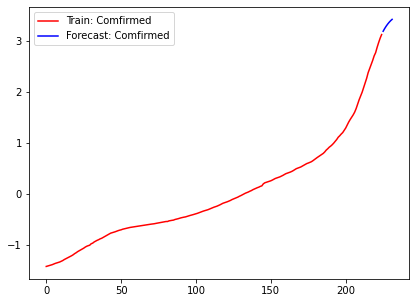

In [195]:
num_state_train = state_temporal_data[current_state].shape[0]
forecast_range = np.arange(num_state_train, num_state_train + forecast_day)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_temporal_data[current_state].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(forecast_range, y_result, color='blue', label='Forecast: Comfirmed')
plt.legend(loc='best')

In [182]:
y_result = np.array(y_result) * state_scaler[current_state].scale_[0] + state_scaler[current_state].mean_[0]

In [183]:
y_result

array([643626.5069039 , 649725.05872732, 654974.35259392, 659517.28863618,
       663443.40469982, 666813.83881443, 669692.9994937 ])

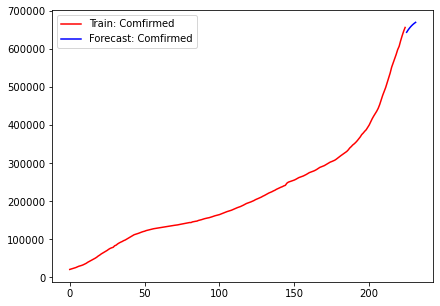

In [184]:
num_state_train = states_data[current_state].shape[0]
validate_range = np.arange(num_state_train, num_state_train+forecast_day)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(np.arange(num_state_train), states_data[current_state]['Confirmed']* state_scaler[current_state].scale_[0] + state_scaler[current_state].mean_[0], color='red', label='Train: Comfirmed')
plt.plot(validate_range, y_result, color='blue', label='Forecast: Comfirmed')
plt.legend(loc='best')

## Train a RNN with LSTM for Every State

In [24]:
num_states = len(states_data.keys())
initialization = np.zeros((forecast_day*num_states, 3))
result_df = pd.DataFrame(initialization, columns=['ForecastID', 'Confirmed', 'Deaths'], dtype='int')

def forcast(window_size, forecast_day, predict_label):
    predict_index = 0
    if predict_label == 'Deaths':
        predict_index = 1
        
    state_count = 0
    for state in states_data.keys():
        current_state = state
        num_state_train = state_train_data[current_state].shape[0]
        num_state_validate = state_validate_data[current_state].shape[0]
        validate_range = np.arange(num_state_train, num_state_train+num_state_validate)
        data_training = np.array(state_train_data[current_state])

        X_train = []
        y_train = []

        for i in range(window_size, data_training.shape[0]-forecast_day):
            X_train.append(data_training[i-window_size:i])
            y_train.append(data_training[i+forecast_day, predict_index])

        X_train, y_train = np.array(X_train), np.array(y_train)
        model = keras.Sequential()

        model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 200, activation = 'relu'))
        model.add(Dropout(0.2))

        model.add(Dense(units = 1))

        # model.summary()

        model.compile(optimizer='adam', loss = 'mean_squared_error')
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

        previous_days = state_train_data[current_state].tail(window_size+forecast_day)
        inputs = np.array(previous_days)
        X_test = []
        y_test = []

        for i in range(window_size, inputs.shape[0]):
            X_test.append(inputs[i-window_size:i])
            y_test.append(inputs[i,predict_index])

        X_test, y_test = np.array(X_test), np.array(y_test)

        y_pred = model.predict(X_test)
        y_result = y_pred.flatten().tolist()
        y_result = np.array(y_result) * state_scaler[current_state].scale_[predict_index] + state_scaler[current_state].mean_[predict_index]

        date_count = 0
        for r in y_result:
            forecast_id = state_count + date_count * num_states
            result_df.loc[forecast_id]['ForecastID'] = forecast_id;
            result_df.loc[forecast_id][predict_label] = r;
            date_count += 1
        state_count += 1

In [25]:
forcast(7, 7, 'Confirmed')
forcast(7, 7, 'Deaths')

KeyboardInterrupt: 

In [ ]:
result_df.to_csv('./data/submission_round2.csv')